# Computing a spectrogram [^download]

[^download]: This notebook can be downloaded as **{nb-download}`example_spectrogram.ipynb`**.

This simple example will only be covered with the **Core API**.

First, create an **OSEkit** `AudioData` from the audio file(s) on disk.
There are multiple ways to do so: here we'll go throught the full process of parsing files into **OSEkit** `AudioFiles`:

In [19]:
from pathlib import Path
from osekit.core_api.audio_file import AudioFile

audio_folder = Path(r"_static/sample_audio")
audio_files = [
    AudioFile(
        path=p,
        strptime_format="%y%m%d_%H%M%S",
    )
    for p in audio_folder.glob("*.wav")
]

Create the `AudioData` you want to plot a spectrogram of from the `AudioFile`s.
The `AudioData` can be freely distributed over multiple files, and you can even resample it.

An `Instrument` can be provided to the `AudioData` for the WAV data to be converted in pressure units. This will lead the resulting spectra to be expressed in dB SPL (rather than in dB FS):

In [20]:
from osekit.core_api.audio_data import AudioData
from osekit.core_api.instrument import Instrument
from pandas import Timestamp

audio_data = AudioData.from_files(
    audio_files,
    begin=Timestamp("2022-09-25 22:34:55"),
    end=Timestamp("2022-09-25 22:35:05"),
    sample_rate=40000,
    normalization="dc_reject",
    instrument=Instrument(end_to_end_db=150.0),
)

Create a `scipy.signal.ShortTimeFFT` with the FFT parameters:

In [21]:
from scipy.signal import ShortTimeFFT
from scipy.signal.windows import hamming

sft = ShortTimeFFT(win=hamming(1024), hop=512, fs=audio_data.sample_rate)

Instantiate an **OSEkit** `SpectroData`, which is the object that will be used to plot spectrograms, export spectrum matrices etc.

In [22]:
from osekit.core_api.spectro_data import SpectroData

spectro_data = SpectroData.from_audio_data(
    data=audio_data,
    fft=sft,
    v_lim=(0.0, 150.0),  # Boundaries of the spectrogram
    colormap="viridis",  # This is the default value
)

Plot the spectrogram using `matplotlib.pyplot`:

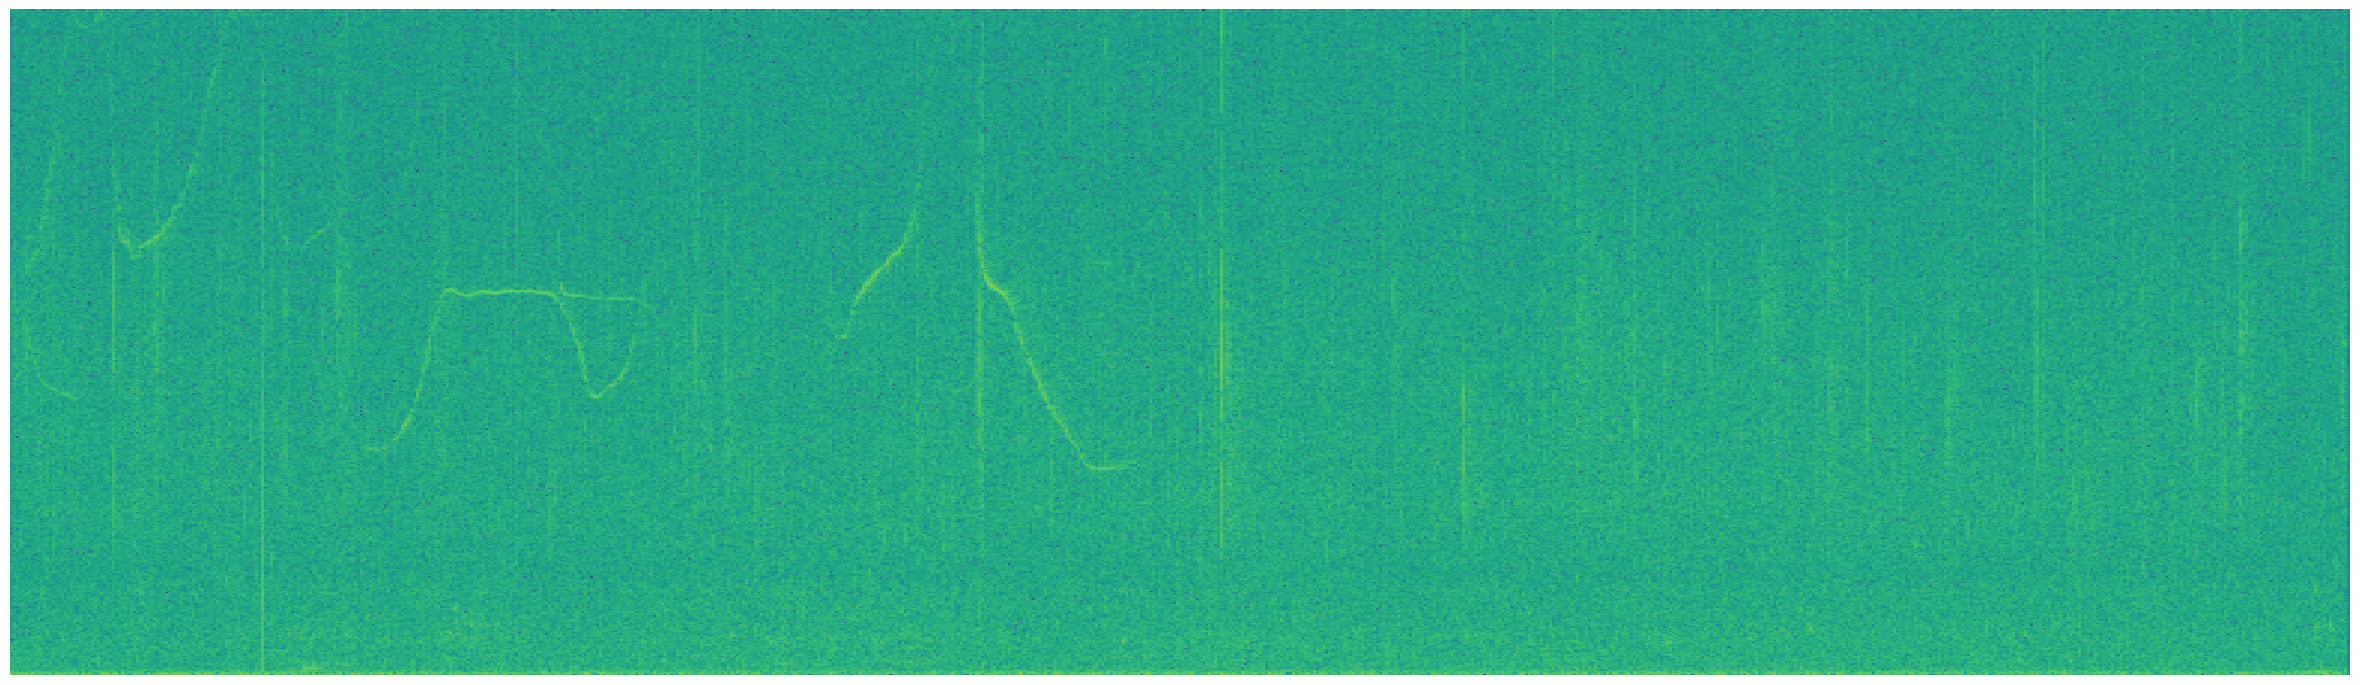

In [23]:
import matplotlib.pyplot as plt

# We store the spectrum matrix here to reuse it later in the notebook, this is not mandatory
sx = spectro_data.get_value()

spectro_data.plot(sx=sx)
plt.show()

You can export both the PNG spectrogram and the NPZ spectrum matrix to file:

In [24]:
# Write a NPZ file with the spectrum matrix:
spectro_data.write(folder=audio_folder / "export", sx=sx)

# Write a PNG image of the spectrogram
spectro_data.save_spectrogram(folder=audio_folder / "export", sx=sx)